# Pooled Inference of α and ∆ε

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mwc.bayes
import mwc.stats
import mwc.model
import mwc.viz
colors = mwc.viz.personal_style()
constants = mwc.model.load_constants()

In this notebook, we explore a means to simultaneously infer the calibration factor $\alpha$ and the DNA binding energy from a collection of single-cell measurements. Rather than clustering data into bins of ATC concentration, we will consider fitting the data to all single cell measurements assuming they are drawn from a master distribution.  

To begin, we will load the data and look at the cumulative distributions of the autofluorescence and constitutive expression samples.

In [2]:
# Load the pooled data
fc_data = pd.read_csv('../../data/compiled_fold_change.csv')
cal_data = pd.read_csv('../../data/compiled_fluctuations.csv')
cal_data = cal_data[cal_data['carbon']=='glucose']
fc_data = fc_data[fc_data['carbon']=='glucose']

# Isolate the autofluorescence and constitutive expression
control_data = fc_data[fc_data['strain'] != 'dilution'].copy()
control_data['total_yfp'] = control_data['mean_yfp'] * control_data['area_pix']
control_data['total_mch'] = control_data['mean_mCherry'] * control_data['area_pix']
control_data['ecdf_yfp'] = control_data.groupby(['strain', 
                                            'date', 
                                            'run_number']
                        )['total_yfp'].transform(
                     lambda x: x.rank(method='first') / len(x))
control_data['ecdf_mch'] = control_data.groupby(['strain', 
                                            'date', 
                                            'run_number']
                        )['total_mch'].transform(
                     lambda x: x.rank(method='first') / len(x))

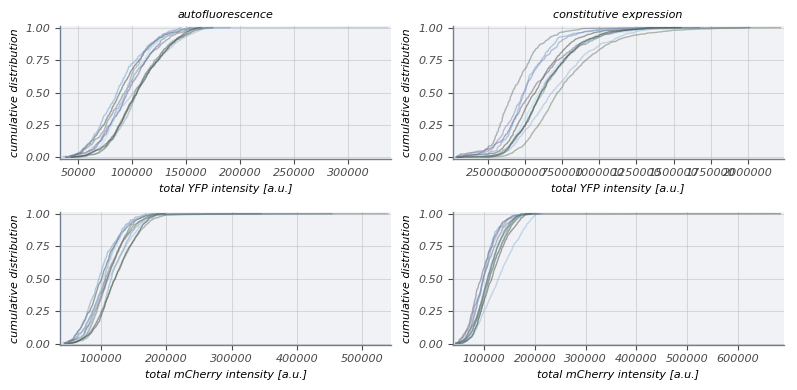

In [3]:
# Instantiate the figure canvas
fig, ax = plt.subplots(2, 2, figsize=(8, 4), dpi=100)
axes = {'auto':0, 'delta':1}
# Plot each individual ecdf
for g, d in control_data.groupby(['strain', 'date', 'run_number']):
    dy = d.copy()
    dm = d.copy()
    dy.sort_values('total_yfp', inplace=True)
    dm.sort_values('total_mch', inplace=True) 
    _yax = ax[0, axes[g[0]]]
    _max = ax[1, axes[g[0]]]
    _ = _yax.plot(dy['total_yfp'], dy['ecdf_yfp'], '-', lw=1, alpha=0.5)
    _ = _max.plot(dm['total_mch'], dm['ecdf_mch'], '-', lw=1, alpha=0.5)
ax[0, 0].set_title('autofluorescence')
ax[0, 1].set_title('constitutive expression')
for i in range(2):
    ax[0, i].set_xlabel('total YFP intensity [a.u.]')
    ax[1, i].set_xlabel('total mCherry intensity [a.u.]')
for a in ax.ravel():
    a.set_ylabel('cumulative distribution')
plt.tight_layout()

In both cases it looks like the autofluorescence and constitutive expression are well behaved. The constitutive expression, as expected is brighter than the autofluorescence by a factor of 10 or so. 
In calculating the calibration factor, I will want to use the autofluorescence samples to extimate the background fluorescence. I will have to model each cell as being drawn from some master distribution. 

In [8]:
model = mwc.bayes.StanModel('../stan/complete_analysis.stan', force_compile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_128513f82f58fe7753c4817052bffcf4 NOW.


Precompiled model not found. Compiling model...


/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmp2n9ikduo/stanfit4anon_model_128513f82f58fe7753c4817052bffcf4_7889853595536599694.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


finished!


In [9]:
# Define the identifiers. 
control_data = control_data[control_data['strain']=='auto'].copy()
control_data['idx'] = control_data.groupby(['date', 'run_number']).ngroup() + 1
cal_data['idx'] = cal_data.groupby(['date', 'run_no']).ngroup() + 1

In [10]:
_control_data = control_data #[control_data['idx']==1]
_cal_data = cal_data #[cal_data['idx']==1]
data_dict = {'N_dil':len(_cal_data),
            'N_con':len(_control_data),
            'J':_cal_data['idx'].max(),
            'idx_dil':_cal_data['idx'].values,
            'idx_con':_control_data['idx'].values,
            'I1':_cal_data['I_1'].values * _cal_data['area_1'],
            'I2':_cal_data['I_2'].values * _cal_data['area_2'],
            'auto_fluo':_control_data['total_yfp']}
fit, samples = model.sample(data_dict, iter=1000)

Beginning sampling...


finished sampling!
